<img src="https://www.python.org/static/img/python-logo.png">

# Welcome to my lessons

---

**Bo Zhang** (NAOC, <mailto:bozhang@nao.cas.cn>) will have a few lessons on python.

- These are **very useful knowledge, skills and code styles** when you use `python` to process astronomical data.
- All materials can be found on [**my github page**](https://github.com/hypergravity/cham_teaches_python).
- **jupyter notebook** (formerly named **ipython notebook**) is recommeded to use

---
These lectures are organized as below:
1. install python
2. basic syntax
3. numerical computing
4. plotting
5. astronomical data processing
6. high performance computing
7. version control


# flowchart
0. test your code **BEFORE** you do **ANY** optimization!
1. find the bottleneck of your code (ps: learn to use profiler to find the bottleneck)
2. use tricks, experience to optimize code
3. use as many computing resources as possible
    1. parallel computing in multi-CPU/core computer (`multiprocessing`, ...)
                
    2. run code on multi-node computer cluster (`PBS`, ...)

# some simple principles for optimization
    1. memory vs. speed
    2. vectorization
    3. type check
    4. parallel    

# recommended packages
    1. numexpr
    2. Cython
    - parallel
        1. multiprocessing (standard library)
        2. ipcluster/ipyparallel (support PBS)


# further reading
1. Parallel Programming with Python
2. Python High performance Programming
3. Learning Cython Programming


# Parallel computing
- **threads**: shared memory, involves locks
- **processes**: isolated memory for each process, inter-process communication is less efficient
    - the easiest way to do parallel computing: **embarassingly parallel** (no inter-process communication), which is the case we met most often

# Monte Carlo approximation for $\pi$

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


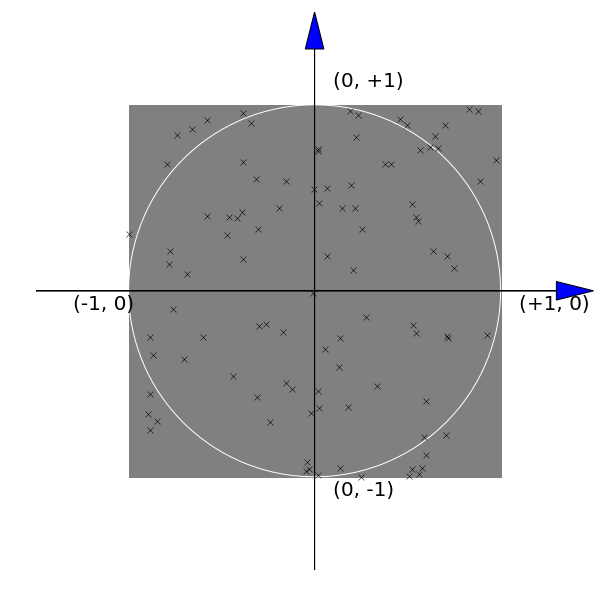

In [4]:
# with plt.xkcd():
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
circle = plt.Circle((0.,0.), 1., color='w', fill=False)
rect = plt.Rectangle((-1,-1), 2, 2, color='gray')
plt.gca().add_artist(rect)
plt.gca().add_artist(circle)
plt.arrow(-2., 0., 3.3, 0., head_width=0.1, head_length=0.2)
plt.arrow(0., -2., 0., 3.3, head_width=0.1, head_length=0.2)
randx = np.random.uniform(-1, 1, (100,))
randy = np.random.uniform(-1, 1, (100,))
plot(randx, randy, 'kx')
plt.gca().axis('off')

plt.text(-1.3, -0.1, '(-1, 0)', fontsize=20)
plt.text( 1.1, -0.1, '(+1, 0)', fontsize=20)
plt.text( 0.1,  1.1, '(0, +1)', fontsize=20)
plt.text( 0.1, -1.1, '(0, -1)', fontsize=20);

In [27]:
%%time

import random
samples = 100000
hits = 0

for i in range(samples):
    x = random.uniform(-1.0, 1.0)
    y = random.uniform(-1.0, 1.0)
    
    if x**2 + y**2 <= 1.0:
        hits += 1
    
pi = 4.0*hits/samples
print pi


3.13616
CPU times: user 124 ms, sys: 0 ns, total: 124 ms
Wall time: 117 ms


## DO NOTICE !

In [28]:
%%time

import multiprocessing

def sample():
    x = random.uniform(-1.0, 1.0)
    y = random.uniform(-1.0, 1.0)
    
    if x**2 + y**2 <= 1.0:
        return 1
    else:
        return 0

pool = multiprocessing.Pool()
results_aysnc = [pool.apply_async(sample) for i in range(samples)]
hits = sum(r.get() for r in results_aysnc)
pool.close()

pi = 4.0*hits/samples
print pi 


3.14116
CPU times: user 15.5 s, sys: 7.74 s, total: 23.3 s
Wall time: 15.2 s


In [29]:
%%time

import multiprocessing

def sample_multiple(samples_partial):
    return sum(sample() for i in range(samples_partial))

ntasks = 10
chunk_size = int(samples/ntasks)

pool = multiprocessing.Pool()
results_aysnc = [pool.apply_async(sample_multiple, [chunk_size]) for i in range(ntasks)]
hits = sum(r.get() for r in results_aysnc)
pool.close()

# pi = 4.0*hits/samples
# print pi 

CPU times: user 46.2 ms, sys: 357 ms, total: 403 ms
Wall time: 426 ms


# ipcluster as an example

In [151]:
from IPython.parallel import Client

In [152]:
rc = Client()

In [153]:
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [154]:
dview = rc[0] # select the first engine
dview

<DirectView 0>

In [155]:
dview = rc[::2] # select every other engine
dview

<DirectView [0, 2, 4, 6,...]>

In [156]:
dview = rc[:] # select all engines
dview

<DirectView [0, 1, 2, 3,...]>

In [159]:
dview.execute('a = 1') # = dview['a']

<AsyncResult: execute>

In [160]:
dview.pull('a').get()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [161]:
dview.push({'a':2}) # = dview['a'] = 2

<AsyncResult: _push>

In [162]:
res = dview.execute('a = T_T')

In [163]:
res.get()

CompositeError: one or more exceptions from call to method: execute
[0:execute]: NameError: name 'T_T' is not defined
[1:execute]: NameError: name 'T_T' is not defined
[2:execute]: NameError: name 'T_T' is not defined
[3:execute]: NameError: name 'T_T' is not defined
.... 8 more exceptions ...

In [165]:
res = dview.execute('b = a+1')

In [166]:
dview['b']

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [169]:
res = dview.execute('b = b+1')

In [170]:
dview['b']

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [171]:
with dview.sync_imports():
    import numpy
    # the syntax import _ as _ is not supported

importing numpy on engine(s)


In [172]:
a = range(100)

In [173]:
def square(x):
    return x*x

In [174]:
dview['b']

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [175]:
results_async = dview.map_async(square, a)
print  results_async.get()

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625, 676, 729, 784, 841, 900, 961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500, 2601, 2704, 2809, 2916, 3025, 3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969, 4096, 4225, 4356, 4489, 4624, 4761, 4900, 5041, 5184, 5329, 5476, 5625, 5776, 5929, 6084, 6241, 6400, 6561, 6724, 6889, 7056, 7225, 7396, 7569, 7744, 7921, 8100, 8281, 8464, 8649, 8836, 9025, 9216, 9409, 9604, 9801]


- engines should be treated as independent IPython sessions
- imports and custom-defined functions must be syncronized over the network.

# parallel decorator

In [176]:
@dview.parallel()
def square(x):
    return x * x

In [177]:
print square.map(range(100)).get()

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625, 676, 729, 784, 841, 900, 961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500, 2601, 2704, 2809, 2916, 3025, 3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969, 4096, 4225, 4356, 4489, 4624, 4761, 4900, 5041, 5184, 5329, 5476, 5625, 5776, 5929, 6084, 6241, 6400, 6561, 6724, 6889, 7056, 7225, 7396, 7569, 7744, 7921, 8100, 8281, 8464, 8649, 8836, 9025, 9216, 9409, 9604, 9801]


# DirectView.apply
- executed on **every** engine

In [178]:
def square(x):
    return x*x

In [179]:
result_async = dview.apply(square, 2)

In [180]:
result_async.get()

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

# scatter & gather

In [181]:
dview.scatter('a', [0, 1, 2, 3])

<AsyncResult: finished>

In [182]:
print dview['a']

[[0], [1], [2], [3], [], [], [], [], [], [], [], []]


In [183]:
dview.scatter('a', np.arange(16))

<AsyncResult: finished>

In [184]:
print dview['a']

[array([0, 1]), array([2, 3]), array([4, 5]), array([6, 7]), array([8]), array([9]), array([10]), array([11]), array([12]), array([13]), array([14]), array([15])]


In [185]:
dview.execute('a = a**2')

<AsyncResult: execute>

In [186]:
print dview['a']

[array([0, 1]), array([4, 9]), array([16, 25]), array([36, 49]), array([64]), array([81]), array([100]), array([121]), array([144]), array([169]), array([196]), array([225])]


In [187]:
dview.gather('a').get()

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225])

# load_balanced_view() (task-based interface)

In [188]:
from IPython.parallel import Client

In [189]:
rc = Client()

In [190]:
tview = rc.load_balanced_view()

In [191]:
def square(x):
    return x * x

In [192]:
dview.apply(square, 2).get()

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [193]:
tview.apply(square, 2).get()

4

In [194]:
tview.apply(square, np.arange(10)).get()

array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])